In [1]:
import torch
import os
import numpy as np
import pandas as pd
from utils import modify_metadata, TARGETS
from input_utils import TrainDataset
from model import EnsembleModel, LinearModel
from training import train, CV_score
import matplotlib.pyplot as plt

/home/barbora/.local/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
TRAIN_METADATA_DIR = "../../data/train.csv"
TRAIN_SIGNATURES_DIR = "../../data/train_signatures/"
train_metadata = pd.read_csv(TRAIN_METADATA_DIR)
train_metadata = modify_metadata(train_metadata)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.KLDivLoss(reduction='batchmean')

In [3]:
train_metadata

,eeg_id,spectrogram_id,eeg_offset_seconds,spec_offset_seconds,patient_id,target,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,789577333,9.0,9.0,20654,Other,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333
1,582999,1552638400,18.0,18.0,20230,LPD,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429
2,1895581,128369999,0.0,1138.0,47999,Other,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154
3,2482631,978166025,24.0,1926.0,20606,Other,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667
4,2521897,673742515,2.0,2.0,62117,Other,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
5934,4291430584,1984115527,15.0,565.0,61174,LPD,0.000000,0.687500,0.000000,0.000000,0.000000,0.312500
5935,4291744526,677970444,14.0,14.0,15506,GRDA,0.000000,0.125000,0.000000,0.000000,0.500000,0.375000
5936,4292809326,75243787,12.0,12.0,18815,Other,0.000000,0.000000,0.000000,0.000000,0.083333,0.916667
5937,4293306306,819682076,0.0,168.0,37409,GPD,0.000000,0.066667,0.400000,0.000000,0.133333,0.400000


In [10]:
# hyperparameters 
signature_level = 4
lr = 0.0007425105458353962
weight_decay = 6.305710445615262e-4
dropout = 0.5
early_stopping_epochs = 50
classifier_input_dim = 256
scaler_type = "meanvar_1.0"
logsigs_or_sigs = "sigs"
hidden_layer_dim = 256

In [11]:
TRAIN_SIGNATURES_FILE = f"{TRAIN_SIGNATURES_DIR}all_{logsigs_or_sigs}_lvl_{signature_level}_scaler_{scaler_type}_experts.pt"
signature_features = torch.load(TRAIN_SIGNATURES_FILE)
dataset = TrainDataset(train_metadata, signature_features)

In [12]:
# train test split
fold_size = len(dataset) // 5
train_dataset = torch.utils.data.Subset(dataset, list(range(fold_size, len(dataset))))
test_dataset = torch.utils.data.Subset(dataset, list(range(fold_size)))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=fold_size, shuffle=False)
sig_dimension = dataset[0][0].shape[1]

In [13]:
ensemble_model = EnsembleModel(sig_dimension, dropout, classifier_input_dim, hidden_layer_dim)
optimizer = torch.optim.Adam(ensemble_model.parameters(), lr=lr, weight_decay=weight_decay)
train_losses, test_losses, model = train(ensemble_model, train_loader, test_loader, device, criterion, optimizer, early_stopping_epochs, max_epochs=100)

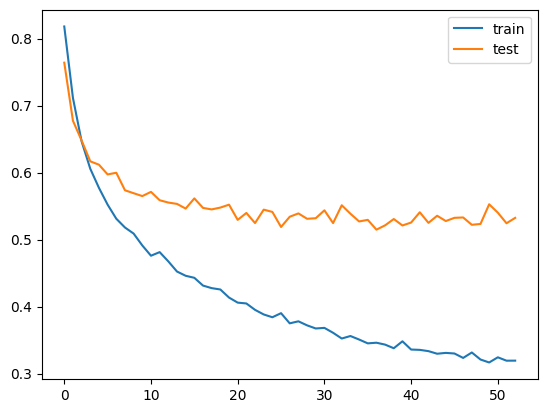

In [14]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

In [15]:
test_losses

[0.7640356421470642,
 0.6773831844329834,
 0.6479178667068481,
 0.616819441318512,
 0.611785352230072,
 0.5972612500190735,
 0.5997828245162964,
 0.5736319422721863,
 0.5692315101623535,
 0.5649657249450684,
 0.5712425708770752,
 0.5587595701217651,
 0.5552987456321716,
 0.5532952547073364,
 0.5463229417800903,
 0.5614947080612183,
 0.5472947955131531,
 0.5450708866119385,
 0.5478019714355469,
 0.5521393418312073,
 0.5294362902641296,
 0.5397800207138062,
 0.5247001647949219,
 0.5447123050689697,
 0.5413269996643066,
 0.5188421607017517,
 0.5341061353683472,
 0.5391039252281189,
 0.5310913324356079,
 0.5318949222564697,
 0.5436992049217224,
 0.5246699452400208,
 0.5512529015541077,
 0.5386551022529602,
 0.5271131992340088,
 0.5294728875160217,
 0.5148679614067078,
 0.5213115215301514,
 0.5307082533836365,
 0.5211135149002075,
 0.5254738330841064,
 0.54079669713974,
 0.524983286857605,
 0.5355910658836365,
 0.527725100517273,
 0.5325127243995667,
 0.5330424904823303,
 0.5221143364906311

In [16]:
# CV scores for each interval
TRAIN_SIGNATURES_FILE = f"{TRAIN_SIGNATURES_DIR}all_{logsigs_or_sigs}_lvl_{signature_level}_scaler_{scaler_type}_experts.pt"
signature_features = torch.load(TRAIN_SIGNATURES_FILE)
dataset = TrainDataset(train_metadata, signature_features)
scores, train_losses, test_losses = CV_score(dataset, lr, weight_decay, dropout, classifier_input_dim, hidden_layer_dim, device, criterion, early_stopping_epochs)